In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from imageai.Detection import ObjectDetection
from IPython.display import clear_output
from sklearn import preprocessing


# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

In [18]:
%run paths.py # Load all our paths
%run methods.py # Load all our methods

detector_name = "yolo"
DETECTIONS_FILE = os.path.join(DATASET_DIR , "detections/"+detector_name+"-detections.csv")

os.listdir(DATASET_DIR)

['test_images',
 'train_masks.zip',
 'train_images.zip',
 'car_models',
 '.ipynb_checkpoints',
 'car_models_json.zip',
 'car_models.zip',
 'test_masks',
 'train.csv',
 'train_images',
 'test_images.zip',
 'train_masks',
 'camera.zip',
 'sample_submission.csv',
 'car_models_json',
 'test_masks.zip',
 'camera']

In [11]:
df_detections = pd.read_csv(DETECTIONS_FILE)
display(df_detections)

,ImageId,Probability,x1,x2,y1,y2,id,yaw,pitch,roll,x,y,z
0,ID_8a6e65317-1,64.780223,1949.0,2172.0,1740.0,1847.0,70.0,0.163072,-1.568650,-3.11754,10.39000,11.22190,59.7825
1,ID_8a6e65317-2,98.063952,2522.0,3050.0,1807.0,2039.0,56.0,0.181647,-1.469470,-3.12159,9.60332,4.66632,19.3390
2,ID_8a6e65317-3,98.919398,2873.0,3384.0,1839.0,2147.0,16.0,0.254839,-2.575340,-3.10256,7.96539,3.20066,11.0225
3,ID_8a6e65317-4,99.524534,607.0,941.0,1727.0,1929.0,70.0,0.141942,-3.139500,3.11969,-9.59236,5.13662,24.7337
4,ID_8a6e65317-1,64.780223,1949.0,2172.0,1740.0,1847.0,70.0,0.163072,-1.568650,-3.11754,10.39000,11.22190,59.7825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55933580,ID_29454123f-4,95.940858,1391.0,1523.0,1762.0,1871.0,16.0,0.147919,0.020073,-3.08263,-3.45690,7.07672,35.6404
55933581,ID_29454123f-5,98.031765,1824.0,1932.0,1773.0,1863.0,16.0,0.147919,0.028850,-3.08263,3.13519,8.09887,40.2738
55933582,ID_29454123f-6,99.310279,2268.0,2631.0,1828.0,2028.0,35.0,0.164734,0.051550,-3.08874,6.99000,5.46318,21.7902
55933583,ID_2dee4d6e6-2,76.999432,584.0,820.0,1710.0,1826.0,35.0,0.166939,3.080810,-3.11637,-14.88920,6.55844,35.4492


In [13]:
"""imgSizes = []

for index,row in df_detections.iterrows():
    
    ImageIdSubId = row["ImageId"]
    ImageIdSubIdList = ImageIdSubId.split("-")
    ImageId = ImageIdSubIdList[0]
    SubId = ImageIdSubIdList[1]
    imagePath = os.path.join(DATASET_DIR , "detections/"+detector_name+"/"+ImageId+".jpg-objects/car-"+SubId+".jpg")
    
    img = open_image(imagePath)
    dimensions = img.shape
    heightImage, widthImage, channels = dimensions
    
    imgSizes.append(heightImage)
    
    clear_output(wait=True)
    print(f"{index+1} Images Analysed. So far, Minimum: {min(imgSizes)}, Maximum: {max(imgSizes)}")
    
    #visualize_image(imagePath,width=5,title=ImageIdSubId)
    
    break"""

#335504 Images Analysed. So far, Minimum: 45, Maximum: 1190
pass

In [14]:
#df_temp = df_detections.head(10000)
df_temp = df_detections.sample(100000)
#df_temp = df_detections.copy() # Take Whole Dataset

totalDetectionsRows = len(df_temp.index)

train_x = []
train_y = []

countedDetectionRows = 0

for index,row in df_temp.iterrows():
    
    countedDetectionRows +=1
    
    ImageIdSubId = row["ImageId"]
    ImageIdSubIdList = ImageIdSubId.split("-")
    ImageId = ImageIdSubIdList[0]
    SubId = ImageIdSubIdList[1]
    imagePath = os.path.join(DATASET_DIR , "detections/"+detector_name+"/"+ImageId+".jpg-objects/car-"+SubId+".jpg")
    #df_temp.loc[index,"filename"] = imagePath 
    
    inputs_extra = np.array([row["x1"],row["y1"],row["x2"],row["y2"]], dtype="float32").reshape(4,-1)    
    min_max_scaler = preprocessing.MinMaxScaler()
    inputs_extra_scaled = min_max_scaler.fit_transform(inputs_extra)
    inputs_extra_scaled = inputs_extra_scaled.reshape(1,-1)
    
    temp_array = img_to_array(open_image(imagePath,square_size=(48,48)))/255.0
    inputs_extra_weighted = np.full((48*12,4),np.array(inputs_extra_scaled))
    temp_array = np.append(temp_array,inputs_extra_weighted).reshape(48,48,-1)    
    
    train_x.append( temp_array )
    train_y.append([row["x"],row["y"],row["z"],row["yaw"],row["pitch"],row["roll"]])
    
    if(countedDetectionRows%500)==0:
        clear_output(wait=True)
        print(f"{countedDetectionRows}/{totalDetectionsRows} Completed. Just tested ImageID-SubID: {ImageIdSubId}")
    
train_x = np.array(train_x)
train_y = np.array(train_y)
df_temp

100000/100000 Completed. Just tested ImageID-SubID: ID_b5ebe839b-1


,ImageId,Probability,x1,x2,y1,y2,id,yaw,pitch,roll,x,y,z
47613094,ID_e43bb7bbd-5,84.553486,851.0,1377.0,1771.0,2018.0,16.0,0.168945,2.787270,-3.11464,-3.362610,2.90866,12.92450
49402144,ID_7d45af237-2,73.365146,748.0,901.0,1706.0,1799.0,8.0,0.147175,-2.941310,-3.11498,-16.608100,7.35553,43.59070
41299969,ID_c74d4703e-3,83.689266,1549.0,1725.0,1744.0,1891.0,40.0,0.145401,0.020915,-3.05658,-0.616433,6.29844,31.70840
35646655,ID_5b0187737-9,99.377614,2781.0,3363.0,1850.0,2589.0,2.0,0.105578,-0.059703,-3.13108,5.109490,2.65295,7.63928
45669094,ID_ca38874e7-8,99.868166,2481.0,3089.0,1872.0,2086.0,35.0,0.127199,1.754040,-3.09066,8.775510,4.97964,18.47490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50685559,ID_0513c9ece-7,93.922150,1373.0,1456.0,1726.0,1793.0,46.0,0.150902,0.025022,-3.07061,-9.520110,14.26350,80.81120
21804818,ID_8210c26cb-4,92.427087,1612.0,1702.0,1743.0,1822.0,46.0,0.138416,-0.095163,-3.11321,-0.752002,13.53010,71.88180
21811951,ID_f997df17b-2,80.455798,2115.0,2350.0,1788.0,1918.0,28.0,0.154225,-0.061176,-3.06369,7.354860,6.68086,29.32180
21190319,ID_7db5caa78-1,69.613951,1123.0,1290.0,1704.0,1811.0,35.0,0.160515,-3.080180,-3.11759,-8.034240,6.49453,38.56940


In [15]:
IMG_HEIGHT, IMG_WIDTH = 48,48
INPUT_SHAPE = train_x.shape[1:]
print(INPUT_SHAPE)

"""train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_data_gen = train_image_generator.flow_from_dataframe(dataframe=df_temp,
                                                           x_col='filename',
                                                           y_col=["x","y","z","yaw","pitch","roll"],                                                           
                                                           #y_col="roll",                                                           
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='raw')"""

pass

(48, 48, 4)


In [16]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(6, activation='linear'))
model.add(layers.Dense(6))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
____

In [17]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [17]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mse','accuracy'])

#history = model.fit_generator(train_data_gen,epochs=50)
epochs = 10

history = model.fit(x=train_x,y=train_y,epochs=epochs,use_multiprocessing=False,verbose=1,validation_split=0.1)

Train on 900000 samples, validate on 100000 samples
Epoch 1/10
900000/900000 [==============================] - 85s 94us/sample - loss: 186.6646 - mean_squared_error: 186.6654 - acc: 0.9917 - val_loss: 106.8741 - val_mean_squared_error: 106.8741 - val_acc: 0.9935
Epoch 2/10
900000/900000 [==============================] - 83s 92us/sample - loss: 67.6273 - mean_squared_error: 67.6270 - acc: 0.9928 - val_loss: 35.1970 - val_mean_squared_error: 35.1970 - val_acc: 0.9945
Epoch 3/10
900000/900000 [==============================] - 83s 92us/sample - loss: 31.1227 - mean_squared_error: 31.1227 - acc: 0.9940 - val_loss: 25.8608 - val_mean_squared_error: 25.8608 - val_acc: 0.9939
Epoch 4/10
900000/900000 [==============================] - 82s 91us/sample - loss: 19.2391 - mean_squared_error: 19.2391 - acc: 0.9940 - val_loss: 15.5505 - val_mean_squared_error: 15.5505 - val_acc: 0.9958
Epoch 5/10
900000/900000 [==============================] - 82s 91us/sample - loss: 14.5807 - mean_squared_error

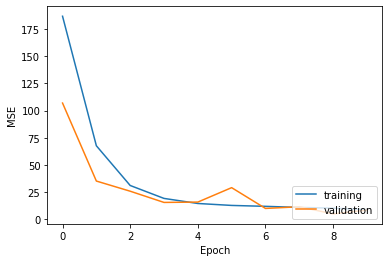

In [18]:
plt.plot(history.history['mean_squared_error'], label='training')
plt.plot(history.history['val_mean_squared_error'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
model.save(os.path.join(MODELS_DIR, f'model_cnn_val_data-{countedDetectionRows}_epochs-{epochs}.h5'))

In [ ]:
#model.predict()

for index,row in df_temp.sample(50).iterrows():
    
    ImageIdSubId = row["ImageId"]
    
    extra_inputs = [row["x1"],row["y1"],row["x2"],row["y2"]]
    temp_array = format_inputs_appended_with_image(ImageIdSubId,extra_inputs,detector_name)
    
    temp_array = np.array([temp_array])
    
    print(model.predict(temp_array))
    print(row["x"],row["y"],row["z"],row["yaw"],row["pitch"],row["roll"])
    
    break

In [ ]:
#from tensorflow.keras.initializers import glorot_uniform
#model = tf.keras.models.load_model('cnn-1.h5',custom_objects={'GlorotUniform': glorot_uniform()})